In [1]:
import pandas as pd
import numpy as np

# Create timesteps
time = np.arange(0, 50, 0.1)

# Assign Amplitude and norlizse above 0
amplitude = np.sin(time)
amplitude = amplitude + 1
max_amp = max(amplitude)
amplitude = amplitude / max_amp

# Contruct DataFrame
df = pd.DataFrame(amplitude)
df.columns = ["Close"]
df["Close_Rt"] = df["Close"].pct_change()
df = df.replace(np.inf, np.nan)
df = df.dropna()
df = df.reset_index(drop=True)

print(f"Length: {len(df)}")
print("Min Close: ", df["Close"].min())
print("Max Close: ", df["Close"].max())
df.head(2)

Length: 499
Min Close:  4.896739968063352e-06
Max Close:  1.0


,Close,Close_Rt
0,0.549918,0.099833
1,0.599337,0.089864


<Axes: >

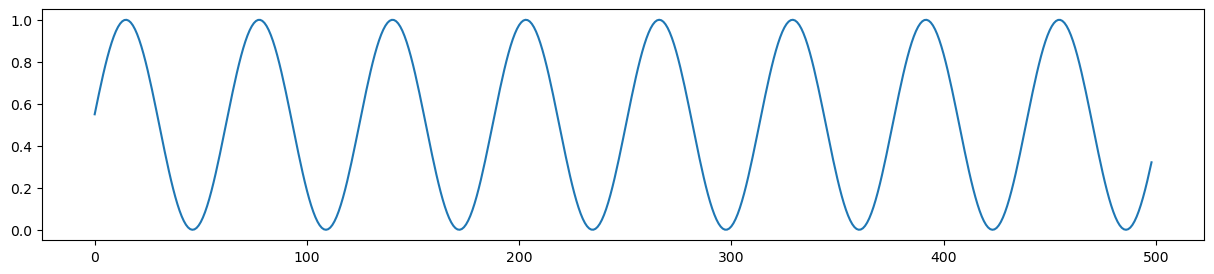

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 3)
df["Close"].plot()

In [17]:
# ENVIRONMENT SET UP AND CLASS

import gym
from gym import spaces
import numpy as np
import random
import torch

# Initialize Variables
MAX_INT = 2147483647
MAX_OPEN_POSITIONS = 1
INITIAL_ACCOUNT_BALANCE = 1000
PERCENT_CAPITAL = 0.1
TRADING_COSTS_RATE = 0.001
KILL_THRESH = 0.4

#Build Environment Class
class StockTradingEnv(gym.Env):
    """
    A stock trading environment with Open AI gym
    """
    metadata = {"render.modes": ['human']}
    
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        
        
        # Generic Variables
        self.df = df
        
        # Account variables
        
        self.account_balance = INITIAL_ACCOUNT_BALANCE
        
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        
        self.realized_profit = 0
        self.unrealized_profit = 0
        self.last_profit = 0
        
        
        # Position Variables
        
        self.open_quantities = []
        self.open_prices = []
        self.trading_costs = 0
        self.open_positions = 0
        self.closed_positions = 0
        self.incorrect_position_calls = 0
        self.num_trades = 0
        self.held_for_period = 0
        
        # Current Step
        self.current_step = 0
        self.max_steps = len(df)
        
        # Actions of the format Long, Hold and Close
        self.action_space = spaces.Discrete(3)
        
        # Setup observation Space
        self.observation_space = spaces.Box(low=-1, high = 1, shape=(8, ), dtype=np.float32)
        
    def _calculate_reward(self):
        reward = 0
        
        if self.num_trades:
            reward += self.realized_profit /self.num_trades
            
            reward += self.unrealized_profit/ self.num_trades* 0.3
            
            reward += 1 if self.last_profit > 0 else 0
            
        reward -= 1 if self.incorrect_position_calls > 0 else 0
        
        if reward <= 0 :
            reward -= 2
        return reward
    
    # Observation Structure
    def _next_observation(self):
        close_item = self.df.loc[self.current_step, "Close"].item()
        close_rt_item = self.df.loc[self.current_step, "Close_Rt"].item()
        close_T1_item = self.df.loc[self.current_step-1, "Close_Rt"].item()
        close_T2_item = self.df.loc[self.current_step-2, "Close_Rt"].item()
        close_T3_item = self.df.loc[self.current_step-3, "Close_Rt"].item()
        close_T4_item = self.df.loc[self.current_step-4, "Close_Rt"].item()
        
        current_position = 1 if self.open_positions else 0
        num_trades = self.num_trades / len(self.df) if self.num_trades > 0 else 0
        
        obs = np.array([close_item, close_rt_item, close_T1_item, close_T2_item,
                        close_T3_item,close_T4_item, current_position, num_trades])
        
        return obs
    
    # Calculate the open position value
    def _calculate_open_value(self):
        open_trades_value = 0
        counts = 0
        for qty in self.open_quantities:
            acquisition_prices = self.open_prices[counts]
            open_trades_value += acquisition_prices * qty
            counts += 1
            
        return open_trades_value
    
    def _profit_calcualtion(self, current_prices, calc_type):
        open_trades_value = self._calculate_open_value()
        total_quanttity_held = sum(self.open_quantities)
        current_value = total_quanttity_held*current_prices
        gross_profit = current_value - open_trades_value
        
        if calc_type == "close_position":
            trading_costs = current_value * TRADING_COSTS_RATE
            self.trading_costs += trading_costs
            
        elif calc_type == "hold_position" or calc_type == "open_position":
            trading_costs = open_trades_value * TRADING_COSTS_RATE
            
        net_profit = gross_profit - trading_costs
        
        return net_profit
    
    #Action management
    def _take_action(self, action):
        current_price = self.df.loc[self.current_step, "Close"].item()
        
        # Reset last profit
        self.last_profit = 0
        self.incorrect_position_calls = 0
        
        # Go Long
        if action == 0:
            if self.open_positions < MAX_OPEN_POSITIONS:
                net_profit = self._profit_calcualtion(current_price, "open_position")
                net_worth = self.net_worth + net_profit
                trading_allowance = net_worth * PERCENT_CAPITAL
                
                self.open_quantities.append(trading_allowance/ current_price)
                self.open_prices.append(current_price)
                self.trading_costs += trading_allowance* TRADING_COSTS_RATE
                self.num_trades += 1
                
            else:
                self.incorrect_position_calls += 1
        
        # Hold
        if action == 1:
            net_profit = self._profit_calcualtion(current_price, "hold_position")
            self.unrealized_profit += net_profit
            if self.open_positions > 0:
                self.held_for_period += 1
                
        # Close  
        if action == 2:
            if self.open_positions != 0:
                net_profit = self._profit_calcualtion(current_price, "close_position")
                self.last_profit = net_profit
                self.realized_profit += net_profit
                self.unrealized_profit = 0
                self.open_quantities = []
                self.open_prices = []
                
                self.held_for_period = 0
                self.closed_positions += 1
            else:
                self.incorrect_position_calls += 1
                
        # Update Variables
        
        open_trades_value = self._calculate_open_value()
        self.open_positions = len(self.open_quantities)
        self.net_worth = INITIAL_ACCOUNT_BALANCE + self.unrealized_profit + self.realized_profit
        self.available_balance = INITIAL_ACCOUNT_BALANCE - open_trades_value + self.realized_profit
        
        # Step Function
        
    def step(self, action):
        self._take_action(action)
        reward = self._calculate_reward
        self.current_step += 1
        is_max_steps_taken = self.current_step >= self.max_steps - 1
        is_account_balance_reached = self.net_worth <= INITIAL_ACCOUNT_BALANCE * KILL_THRESH
        done = True if is_max_steps_taken or is_account_balance_reached else False
        obs = self._next_observation()
        
        return obs, reward, done, {} 
    
    
    def reset(self):
        self.account_balance = INITIAL_ACCOUNT_BALANCE
        
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        
        self.realized_profit = 0
        self.unrealized_profit = 0
        self.last_profit = 0
        
        # Position Variables
        
        self.open_quantities = []
        self.open_prices = []
        self.trading_costs = 0
        self.open_positions = 0
        self.closed_positions = 0
        self.incorrect_position_calls = 0
        self.num_trades = 0
        self.held_for_period = 0
        
        self.current_step = 5
        
        return self._next_observation()
    
    # Render the environment to the screen
    
    def render(self, mode='human', close=False):
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE
        return profit

In [18]:
# Test the Environment

env = StockTradingEnv(df)
actions = [0, 1, 2]
observation = env.reset()
print('Initial observation: ',  env.reset())

for action in actions:
    obs_, reward, done, info = env.step(action)
    print("")
    print("Action Taken: ", action)
    print("Reward Received: ", reward)
    print("Next State: ", obs_)
    print("Completed: ", done)
    print("------------")
    print("Available Balance: ", env.available_balance)
    print("Net worth: ", env.net_worth)
    print("Realized Profit: ", env.realized_profit)
    print("Unrealized Profit: ", env.unrealized_profit)
    print("Open Quantities: ", env.open_quantities)
    print("Open Price: ", env.open_prices)
    
    print("Trading Cost: ", env.trading_costs)
    print("Open Position: ", env.open_positions)
    print("Incorrect Calls: ", env.incorrect_position_calls)
    print("------------- ")
    
    

Initial observation:  [0.78232368 0.05760137 0.06478049 0.0724791  0.08079866 0.08986444
 0.         0.        ]

Action Taken:  0
Reward Received:  <bound method StockTradingEnv._calculate_reward of <__main__.StockTradingEnv object at 0x000001C76CB50E10>>
Next State:  [0.82211142 0.0508584  0.05760137 0.06478049 0.0724791  0.08079866
 1.         0.00200401]
Completed:  False
------------
Available Balance:  900.0
Net worth:  1000
Realized Profit:  0
Unrealized Profit:  0
Open Quantities:  [127.82432899941284]
Open Price:  [0.782323684253092]
Trading Cost:  0.1
Open Position:  1
Incorrect Calls:  0
------------- 

Action Taken:  1
Reward Received:  <bound method StockTradingEnv._calculate_reward of <__main__.StockTradingEnv object at 0x000001C76CB50E10>>
Next State:  [0.85868073 0.04448219 0.0508584  0.05760137 0.06478049 0.0724791
 1.         0.00200401]
Completed:  False
------------
Available Balance:  900.0
Net worth:  1004.9858400686253
Realized Profit:  0
Unrealized Profit:  4.98